# Covid preprocessing 

In [3]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr

# Import data and some first pre-processing steps

This notebook performs the needed preprocessing of the COVID-19 dataset used in our article. First, get the data from the article Paireau, J., Andronico, A., Hozé, N., Layan, M., Crepey, P., Roumagnac, A., ... & Cauchemez, S. (2022). An ensemble model based on early predictors to forecast COVID-19 health care demand in France. Proceedings of the National Academy of Sciences, 119(18), e2103302119, by using the following GitHub link. 

https://gitlab.pasteur.fr/mmmi-pasteur/covid19-ensemble-model

Please dowload the dataframe called `full_data.rds`. Modify the datapath bellow accordingly.  

In [ ]:
data_path = "SET_DATA_PATH"

In [4]:
result = pyreadr.read_r(data_path + "full_data.rds") # also works for RData
data = result[None]

In [5]:
data['date'] = pd.to_datetime(data['date'])
data['date_analysis'] = pd.to_datetime(data['date_analysis'])

### Defining regions

In [7]:
regions = ["ARA", "BFC", "BRE", "CVL",  "GES", "HDF", "IDF", "NOR",
                      "NAQ", "OCC", "PDL", "PAC"]

### Chosing periods (period 2 has more features)

In [8]:
data_period2 = data.loc[data['date']>="2021-03-07"]

123

We drop all non-smooth variables and the target. 

In [9]:
data_period2_simple = data_period2.drop([
       'iHosp_smooth_lwr', 'iHosp_smooth_upr', 
       'iICU_smooth_lwr', 'iICU_smooth_upr',  
       'inHosp_smooth_lwr', 'inHosp_smooth_upr','retail_and_recreation', 'grocery_and_pharmacy', 'parks',
       'transit_stations', 'workplaces', 'residential',
       'retail_and_recreation_smooth', 
       'inICU_smooth_lwr', 'inICU_smooth_upr', 
       'prop_pos', 'prop_pos80', 'P70', 'P_smooth', 'prop_pos_symp',
       'prop_pos_smooth', 'prop_pos80_smooth', 'P70_smooth', 'P70_r',
       'prop_pos_symp_r', 'prop_pos_r',  'rel_humidity', 'abs_humidity', 'IPTCC',
                                                 'temperature','prop_pos80_r', 'propV123']
                                                ,axis =1)

### Depth of history

We set the size of the window to $10$. 

In [12]:
horizon_back = 10 ## hyperparameter

### Horizon of prediction


In [13]:
horizons = np.arange(1,15)
first_pred = horizon_back + 1
length_prediction = len(horizons)

In [14]:
first_pred = data_period2_simple['date'].min() + pd.Timedelta(days=horizon_back) + \
                                                    pd.Timedelta(days=horizons.max())
first_pred

Timestamp('2021-03-31 00:00:00')

In [16]:
data_period2_simple = data_period2_simple.loc[data_period2_simple['date_analysis']=='2021-07-09']

In [17]:
n_days = data_period2_simple['date'].max() - first_pred
n_obs = n_days * len(data_period2_simple['region'].unique())

# Some plots 

A short graphical interlude to look at some plots of our data. 

In [20]:
feature_list = ['prop_pos_symp_smooth', 'grocery_and_pharmacy_smooth', 'parks_smooth',
       'transit_stations_smooth', 'workplaces_smooth', 'residential_smooth',
       'IPTCC_smooth', 'temperature_smooth', 'rel_humidity_smooth',
       'abs_humidity_smooth', 'P_r', 'couv_complet', 'time']

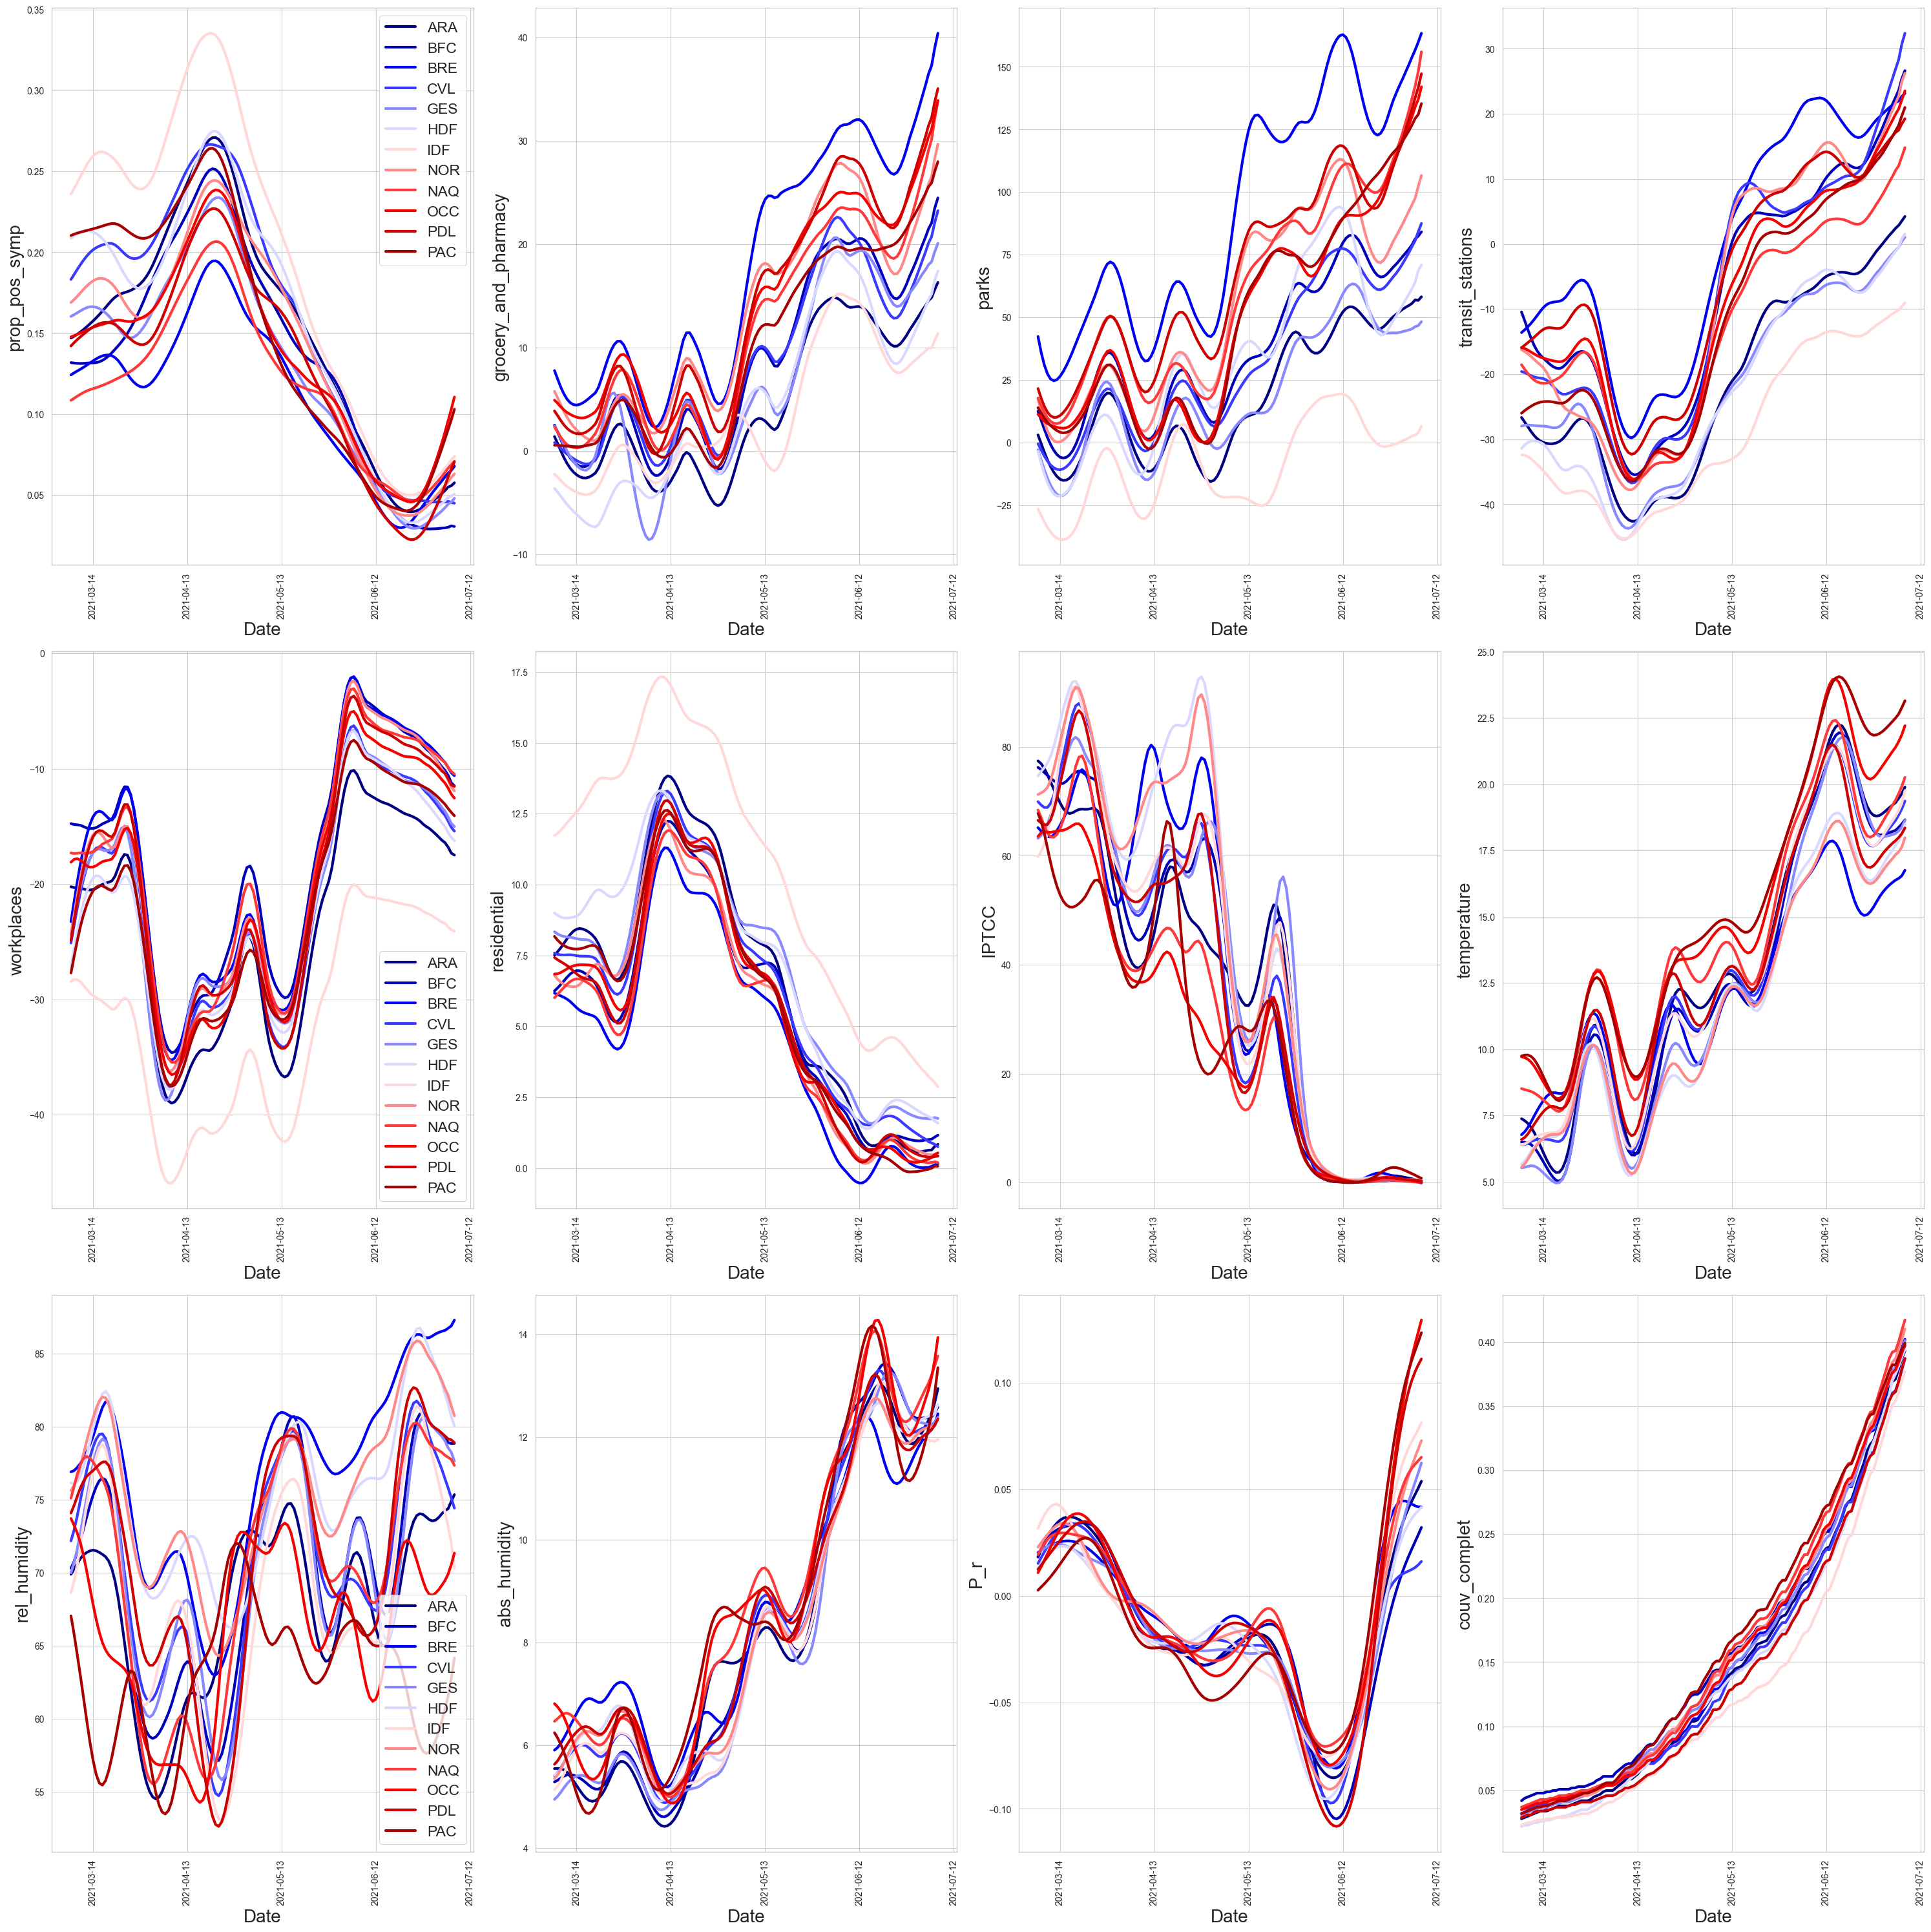

In [21]:
color_map = color_palette = sns.color_palette("seismic",n_colors=12).as_hex()
sns.set_context('paper')
sns.set_style('whitegrid')

f,ax = plt.subplots(3,4,figsize=(30,30))
for j,region in enumerate(["ARA", "BFC", "BRE", "CVL",  "GES", "HDF", "IDF", "NOR",
                      "NAQ", "OCC", "PDL", "PAC"]):
    data = data_period2_simple[data_period2_simple.region==region]
    for i,feature in enumerate(feature_list[:-1]):
        if i in [0,4,8]:
            sns.lineplot(x='date',y=feature,data=data,ax=ax[i//4,i%4],linewidth=3,c=color_map[j],label=region)
            ax[i//4,i%4].legend(fontsize='xx-large')
        else:
            sns.lineplot(x='date',y=feature,data=data,ax=ax[i//4,i%4],linewidth=3,c=color_map[j])
        ax[i//4,i%4].xaxis.set_major_locator(plt.MaxNLocator(5))
        ax[i//4,i%4].tick_params(axis='x',which='major',labelsize=10,rotation=90)
        ax[i//4,i%4].tick_params(axis='y',which='major',labelsize=10)
        ax[i//4,i%4].set_xlabel(xlabel='Date', fontsize=20)
        if feature[-7:] == '_smooth':
            ax[i//4,i%4].set_ylabel(ylabel=feature[:-7], fontsize=20)
        else: 
            ax[i//4,i%4].set_ylabel(ylabel=feature, fontsize=20)
        
plt.tight_layout()
#plt.savefig('covid_features.pdf')

Text(0, 0.5, 'Hospitalization growth rate')

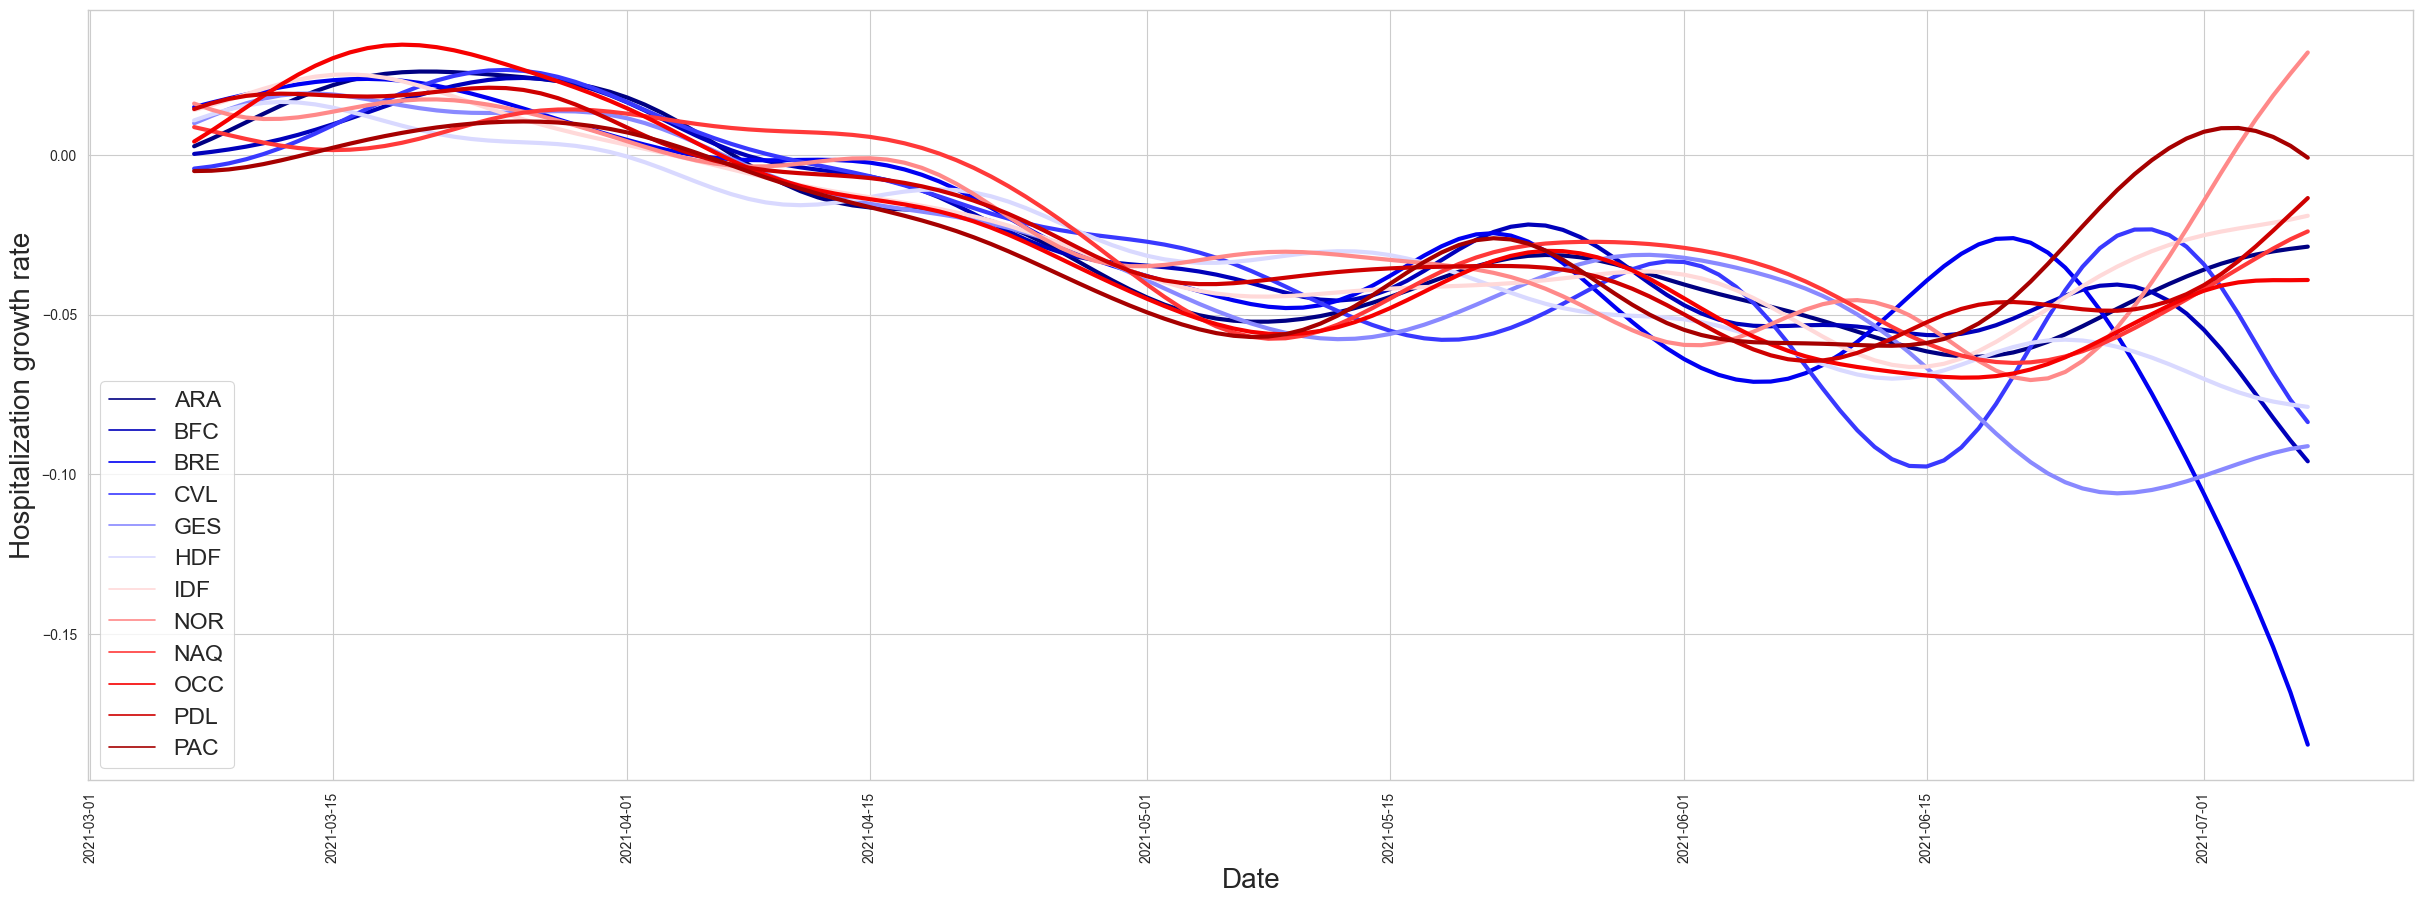

In [22]:
data_period2_wmet = data_period2_simple[data_period2_simple.region.isin(["ARA", "BFC", "BRE", "CVL",  "GES", "HDF", "IDF", "NOR",
                      "NAQ", "OCC", "PDL", "PAC"])]


f,ax=plt.subplots(figsize=(30,10))
sns.lineplot(x = 'date',
             y = 'iHosp_r',
            hue = 'region',
            palette='seismic',
            data = data_period2_wmet,linewidth=3,ax=ax)

ax.tick_params(axis='x',which='major',labelsize=10,rotation=90)
ax.tick_params(axis='y',which='major',labelsize=10)
ax.set_xlabel(xlabel='Date', fontsize=20)
ax.legend(fontsize='xx-large')
ax.set_ylabel(ylabel='Hospitalization growth rate', fontsize=20)

#plt.savefig('covid_target.pdf')

## Tensor creation

Let us go back to data cleaning. 

In [23]:
dates = data_period2_simple.loc[data_period2_simple['date']>=first_pred]['date'].unique()

In [24]:
dates_train = dates[:-14]
dates_test = dates[-14:]

In [25]:
n_days_train = len(dates_train)
n_obs_train = n_days_train * len(regions)
n_days_test = len(dates_test)
n_obs_test = n_days_test * len(regions)

In [26]:
features_names = ['prop_pos_symp_smooth',
       'grocery_and_pharmacy_smooth', 'parks_smooth',
       'transit_stations_smooth', 'workplaces_smooth', 'residential_smooth',
       'IPTCC_smooth', 'temperature_smooth', 'rel_humidity_smooth',
       'abs_humidity_smooth', 'P_r', 'couv_complet']

In [27]:
d_features = len(features_names)

In [28]:
#(n_individus, n_temps_de_mesure, dimensions)
data_tensor_train = torch.empty((len(horizons),n_obs_train,horizon_back,d_features+1))
label_tensor_train = torch.empty((len(horizons),n_obs_train,1))
data_tensor_test = torch.empty((len(horizons),n_obs_test,horizon_back,d_features+1))
label_tensor_test = torch.empty((len(horizons),n_obs_test,1))
print(data_tensor_train.shape)

torch.Size([14, 1020, 10, 13])


In [29]:
index_train_day = []
index_train_region = []
index_test_day = []
index_test_region = []
for horizon in horizons:
    d_train = 0
    d_test = 0
    for day in dates:
        data_label = data_period2_simple.loc[data_period2_simple['date']== day]
        data_features = data_period2_simple.loc[data_period2_simple['date']<= \
                           pd.to_datetime(day -  pd.Timedelta(days=horizon)).strftime('%Y-%m-%d')]

        data_features = data_features.loc[data_features['date']> \
                           pd.to_datetime(day -  pd.Timedelta(days=horizon)- \
                                          pd.Timedelta(days=horizon_back)).strftime('%Y-%m-%d')] 


        for region in regions:
            data_label_region = data_label.loc[data_label['region'] == region]
            data_feature_region = data_features.loc[data_features['region'] == region]
            data_feature_region = data_feature_region.loc[:,features_names]
            data_feature_region['time'] = np.arange(pd.Timedelta(days=horizon_back).days)
            #print(data_feature_region)
            if day <= dates_train.max():
                label_tensor_train[horizon-1,d_train,:] = torch.from_numpy(data_label_region['iHosp_r'].to_numpy())
                data_tensor_train[horizon-1,d_train,:,:] = torch.from_numpy(data_feature_region.to_numpy(dtype=np.float16))
                d_train +=1
                if horizon == 1:
                    index_train_day.append(day)
                    index_train_region.append(region)
            else :
                label_tensor_test[horizon-1,d_test,:] = torch.from_numpy(data_label_region['iHosp_r'].to_numpy())
                data_tensor_test[horizon-1,d_test,:,:] = torch.from_numpy(data_feature_region.to_numpy(dtype=np.float16))
                d_test +=1
                    
                if horizon == 1:
                    index_test_day.append(day)
                    index_test_region.append(region)

        

This last cell saves the pre-processed data as `.pkl` files. 

In [40]:
torch.save([horizons,dates,regions,horizon_back,data_tensor_train,\
            features_names,index_train_day,index_train_region], data_path + "data_features_train_preprocessed.pkl")
torch.save([horizons,horizon_back,label_tensor_train], data_path + "data_label_train_preprocessed.pkl")
torch.save([horizons,dates,regions,horizon_back,data_tensor_test, \
            features_names,index_test_day,index_test_region], data_path + "data_features_test_preprocessed.pkl")
torch.save([horizons,horizon_back,label_tensor_test], data_path + "data_label_test_preprocessed.pkl")